<a id="introduction"></a>
## Introduction to Clustering
#### By Paul Hendricks
-------

Clustering is an important technique for helping data scientists partition data, especially when that data doesn't have labels or annotations associated with it. Since these data often don't have labels, clustering is often described as an unsupervised learning technique. While there are many different algorithms that partition data into unique clusters, we will show in this notebook how in certain cases the DBSCAN algorithm can do a better job of clustering than traditional algorithms such as K-Means or Agglomerative Clustering. 

We will also show how to cluster data with K-Means and DBSCAN in NVIDIA RAPIDS – an open-source data analytics and machine learning acceleration platform that leverages GPUs to accelerate computations. We will see that porting this example from CPU to GPU is trivial and that we can experience massive performance gains by doing so.

In this notebook, we will describe K-Means and DBSCAN - several popular clustering algorithms - and show how to use the GPU accelerated implementation of these algorithms in RAPIDS.

**Table of Contents**

* [Introduction to Clustering](#introduction)
* [Setup](#setup)
* [Generating Data](#generate)
* [Overview of K-Means and Agglomerative Clustering](#overview)
* [Clustering using DBSCAN](#dbscan)
* [Accelerating Clustering with RAPIDS](#accelerating)
* [Clustering using GPU Accelerated K-Means](#gpukmeans)
* [Benchmarking: Comparing GPU and CPU](#benchmarking)
* [K-Means](#benchmarkingkmeans)
  * [GPU](#benchmarkingkmeansgpu)
  * [CPU](#benchmarkingkmeanscpu)
* [DBSCAN](#benchmarkingdbscan)
  * [GPU](#benchmarkingdbscangpu)
  * [CPU](#benchmarkingdbscancpu)
* [Conclusion](#conclusion)

Before going any further, let's make sure we have access to `matplotlib`, a popular Python library for visualizing data.

In [1]:
import os

try:
    import matplotlib; print('Matplotlib Version:', matplotlib.__version__)
except ModuleNotFoundError:
    os.system('conda install -y matplotlib')

Matplotlib Version: 3.1.0


<a id="setup"></a>
## Setup

This notebook was tested using the following Docker containers:

* `FROM rapidsai/rapidsai-nightly:0.8-cuda10.0-devel-ubuntu18.04-gcc7-py3.7` from [DockerHub - rapidsai/rapidsai-nightly](https://hub.docker.com/r/rapidsai/rapidsai-nightly)

This notebook was run on the NVIDIA Tesla V100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here: https://github.com/rapidsai/notebooks/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [2]:
!nvidia-smi

Sun Jun  9 21:26:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    42W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   37C    P0    45W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

Next, let's see what CUDA version we have:

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


Next, let's load some helper functions from `matplotlib` and configure the Jupyter Notebook for visualization.

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


%matplotlib inline

<a id="generate"></a>
## Generating Data

We'll generate some fake data using the `make_moons` function from the `sklearn.datasets` module. This function generates data points from two equations, each describing a half circle with a unique center. Since each data point is generated by one of these two equations, the cluster each data point belongs to is clear. The ideal clustering algorithm will identify two clusters and associate each data point with the equation that generated it.

In [5]:
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=int(1e2), noise=0.05, random_state=0)
print(X.shape)

Scikit-Learn Version: 0.21.2
(100, 2)


Let's visualize our data:

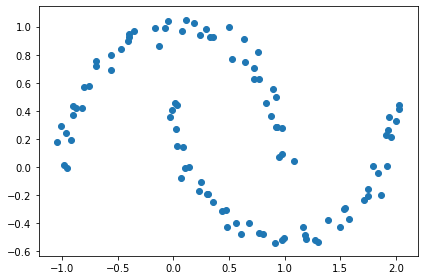

In [6]:
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

<a id="overview"></a>
## Overview of K-Means and Agglomerative Clustering

There exist several algorithms for partitioning data into partitions, two of the more common of which are called K-Means and Agglomerative Clustering.

The K-Means algorithm approaches the clustering problem by partitioning a set of data points into disjoint clusters, where each cluster is described by the mean of the samples in the cluster. The mean of the samples in a particular cluster is called a centroid; the K-Means algorithm finds the centroids and associates data points with centroids in such a way as to minimize the within-cluster sum-of-squares.

For more information on the K-Means algorithm and its implementatin in scikit-learn, check out this resource: http://scikit-learn.org/stable/modules/clustering.html#k-means

In the code cell below, we instantiate the `KMeans` algorithm from the `sklearn.cluster` module and apply it to our data using the `fit_predict` method. We see that `KMeans` identifies two centroids; one located at about (-0.23, 0.56) and the other located at (1.17, -0.05).

In [7]:
from sklearn.cluster import KMeans


km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
print(km.cluster_centers_)

[[ 1.17408322 -0.05027964]
 [-0.23011109  0.56790752]]


The Agglomerative Clustering algorithm behaves a little bit differently and does not identify clusters using centroids. Instead, it recursively merges the pair of clusters that minimally increases a given linkage distance. Put another way, the Agglomerative Clustering algorithm identifies the two data points that are "closest" out of all the data samples. It then takes those two data points and identifies a third data point that is "closest" to those two data points. The algorithm continues in this fashion for each data point; finding the next data point that is "closest" to the preceeding cluster of data points, where the definition of "closest" depends on the distance metric chosen.

For more information on the Agglomerative Clustering algorithm and its implementatin in scikit-learn, check out this resource: http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

Below, we instantiate the `AgglomerativeClustering` algorithm from the `sklearn.cluster` module and apply it to our data.

In [8]:
from sklearn.cluster import AgglomerativeClustering


ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)

We can visualize the results of both algorithms applied to the data. Visually, we see that neither algorithm ideally clusters our data. The ideal algorithm for this unique set of data would recognize that both sets of samples are generated from two different equations describing two different half circles.

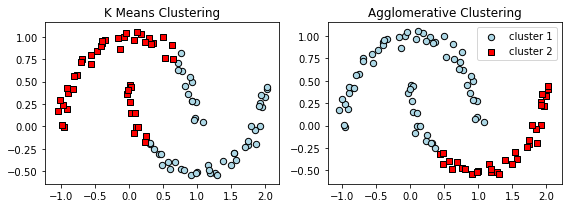

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))


ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K Means Clustering')


ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative Clustering')

plt.legend()
plt.tight_layout()
plt.show()

<a id="dbscan"></a>
## Clustering using DBSCAN

Unlike K Means or Agglomerative Clustering, DBSCAN is a density-based approach to spatial clustering. It views clusters as areas of high density separated by areas of low density. This approach has several advantages; whereas K Means focuses on finding centroids and assoicating data points with that centroid in a spherical manner, the DBSCAN algorithm can identify clusters of any convex shape. Additionally, DBSCAN is robust to areas of low density. In the above visualization, we see that Agglomerative Clustering ignores the low density space space between the interleaving circles and instead focuses on finding a clustering hierarchy that minimizes the Euclidean distance. While minimizing Euclidean distance is important for some clustering problems, it is visually apparent to a human that following the density trail of points results in the ideal clustering. 

For more information on the DBSCAN algorithm and its implementation in scikit-learn, check out this resource: http://scikit-learn.org/stable/modules/clustering.html#dbscan

In [10]:
from sklearn.cluster import DBSCAN


db = DBSCAN(eps=0.2, min_samples=2)

Next, let's fit our model to the data and generate predictions.

In [11]:
y_db = db.fit_predict(X)

Lastly, let's visualize the model applied to our data. We see that the DBSCAN algorithm correctly identifies which half-circle each data point is generated from.

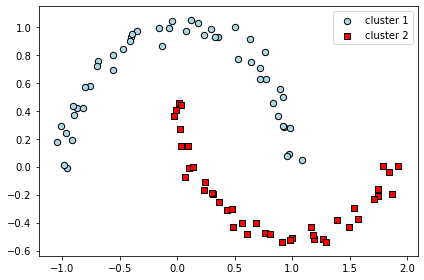

In [12]:
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

<a id="accelerating"></a>
## Accelerating Clustering with RAPIDS

So how can we accelerate our code using RAPIDS? First, we cast our data to a `pandas.DataFrame` and use that to create a `cudf.DataFrame`. 

In [13]:
import cudf; print('cuDF Version:', cudf.__version__)
import pandas as pd; print('Pandas Version:', pd.__version__)


X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gdf = cudf.DataFrame.from_pandas(X_df)

cuDF Version: 0.7.2+0.g3ebd286.dirty
Pandas Version: 0.23.4


<a id="gpukmeans"></a>
## Clustering using GPU Accelerated K-Means

Next, we load the `KMeans` class from the `cuml` package and instantiate it in the same way we did with the `sklearn.cluster.KMeans` class.

In [14]:
from cuml import KMeans as KMeansGPU


km_gpu = KMeansGPU(n_clusters=2)

The `KMeans` class from `cuml` implements the same API as the `sklearn` version; we can use the `fit` and `fit_predict` methods to fit our `KMeans` model to the data and generate predictions.

In [15]:
y_km_gpu = km_gpu.fit_predict(X_gdf)

Lastly, let's visualize our results:

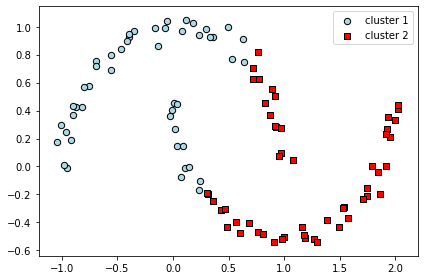

In [16]:
plt.scatter(X[y_km_gpu == 0, 0], X[y_km_gpu == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_km_gpu == 1, 0], X[y_km_gpu == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

<a id="gpudbscan"></a>
## Clustering using GPU Accelerated DBSCAN

Next, we load the `DBSCAN` class from the `cuml` package and instantiate it in the same way we did with the `sklearn.cluster.DBSCAN` class.

In [17]:
import cuml; print('cuML Version:', cuml.__version__)

cuML Version: 0.8.0a+1003.g7f9e070c


In [18]:
from cuml import DBSCAN as DBSCANGPU

db_gpu = DBSCANGPU(eps=0.2, min_samples=2)

The `DBSCAN` class from `cuml` implements the same API as the `sklearn` version; we can use the `fit` and `fit_predict` methods to fit our `DBSCAN` model to the data and generate predictions.

In [19]:
y_db_gpu = db_gpu.fit_predict(X_gdf)

Lastly, let's visualize our results:

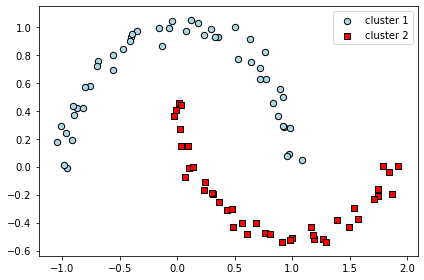

In [20]:
plt.scatter(X[y_db_gpu == 0, 0], X[y_db_gpu == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db_gpu == 1, 0], X[y_db_gpu == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

<a id="benchmarking"></a>
## Benchmarking: Comparing GPU and CPU

RAPIDS uses GPUs to parallelize operations and accelerate computations. We saw porting an example from the traditional scikit-learn interface to cuML was trivial. So how much speedup do we get from using RAPIDS? 

The answer to this question varies depending on the size and shape of the data. As a good rule of thumb, larger datasets will benefit from RAPIDS. There is overhead associated with using a GPU; data has to be transferred from the CPU to the GPU, computations have to take place on the GPU, and the results need to be transferred back from the GPU to the CPU. However, the transactional overhead of moving data back and forth from the CPU to the GPU can quickly become negligible due to the performance speedup from computing on a GPU instead of a CPU.

Feel free to change the number of rows and columns to see how this speedup might change depending on the size and shape of the data.

In [21]:
import numpy as np; print('NumPy Version:', np.__version__)

n_rows, n_cols = 100000, 128
X = np.random.rand(n_rows, n_cols)
print(X.shape)

NumPy Version: 1.16.2
(100000, 128)


In [22]:
X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gdf = cudf.DataFrame.from_pandas(X_df)

<a id="benchmarkingkmeans"></a>
## K-Means

<a id="benchmarkingkmeansgpu"></a>
### GPU

In [23]:
km_gpu = KMeansGPU(n_clusters=2)

In [24]:
%%time

y_km_gpu = km_gpu.fit_predict(X_gdf)

CPU times: user 326 ms, sys: 64.7 ms, total: 391 ms
Wall time: 651 ms


<a id="benchmarkingkmeanscpu"></a>
### CPU

In [25]:
km = KMeans(n_clusters=2)

In [26]:
%%time

y_km = km.fit_predict(X)

CPU times: user 1min 40s, sys: 14.6 s, total: 1min 55s
Wall time: 36.2 s


<a id="benchmarkingdbscan"></a>
## DBSCAN

<a id="benchmarkingdbscangpu"></a>
### GPU

In [27]:
db_gpu = DBSCANGPU(eps=3, min_samples=2)

In [28]:
%%time

y_db_gpu = db_gpu.fit_predict(X_gdf)

CPU times: user 346 ms, sys: 1.01 s, total: 1.36 s
Wall time: 1.44 s


<a id="benchmarkingdbscancpu"></a>
### CPU

In [29]:
db = DBSCAN(eps=3, min_samples=2)

In [30]:
%%time

print('This takes a very long time!')
# y_db = db.fit_predict(X)  # uncomment this line to execute - run at your own risk of boredom!

This takes a very long time!
CPU times: user 337 µs, sys: 55 µs, total: 392 µs
Wall time: 226 µs


<a id="conclusion"></a>
## Conclusion

In this notebook, we described K-Means and DBSCAN - several popular clustering algorithms - and showed how to use the GPU accelerated implementation of these algorithms in RAPIDS.

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)
